
=== MW BVP: λ=0.0, η=0.0 çözülüyor ===
Training PINN for λ=0.0, η=0.0, Re=196
[OBS DEBUG] λ=0.0, η=0.0, Re=196
  X_obs shape: (100, 2)
  z range     : 0.0 → 10.0
  U min/max   : -1.0587911840678754e-22 → 0.18072177469730377
  V min/max   : -1.0 → 0.0
  W min/max   : -0.882598876953125 → 0.0
Compiling model...
'compile' took 0.000222 s

Training model...

0         [1.64e-03, 5.88e-03, 1.77e-03, 4.48e-09, 1.45e-08, 1.27e-07, 7.06e-11, 7.04e-07, 8.78e-06, 5.85e+00, 8.17e+00, 1.14e-06, 1.16e-01, 1.25e+00, 3.17e-01]    [2.08e-03, 7.40e-03, 2.11e-03, 4.91e-09, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.16e-01, 1.25e+00, 3.17e-01]    []  
500       [2.39e-04, 7.23e-05, 3.00e-05, 7.99e-06, 3.03e-10, 1.54e-08, 9.86e-09, 4.07e-12, 2.34e-09, 1.06e-07, 2.82e-07, 2.64e-08, 2.50e-04, 3.21e-04, 1.47e-02]    [5.75e-05, 2.03e-05, 2.26e-05, 5.78e-06, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.50e-04, 3.21e-04, 1.47e-02]    [

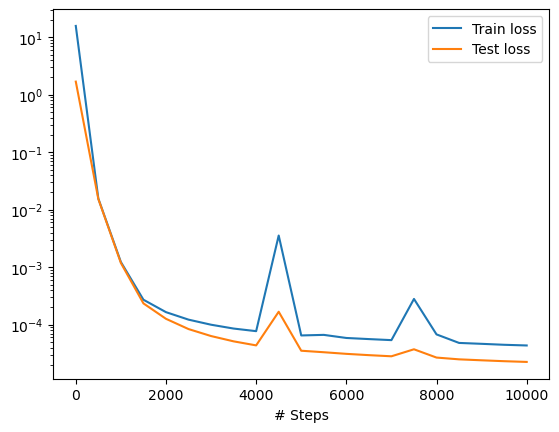

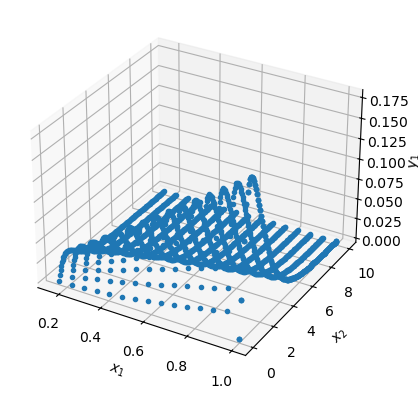

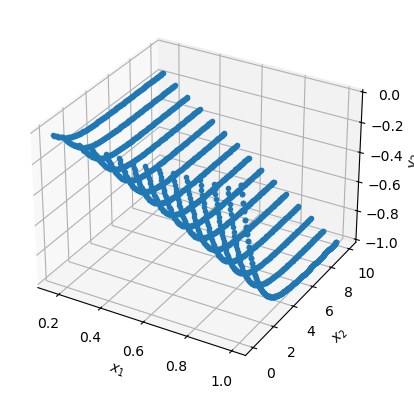

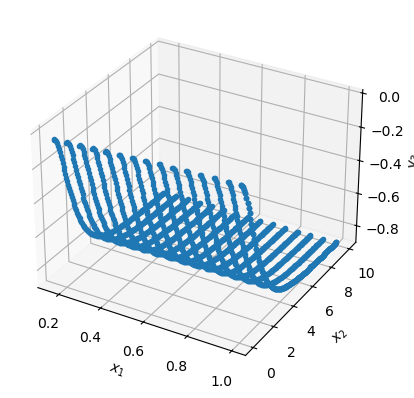

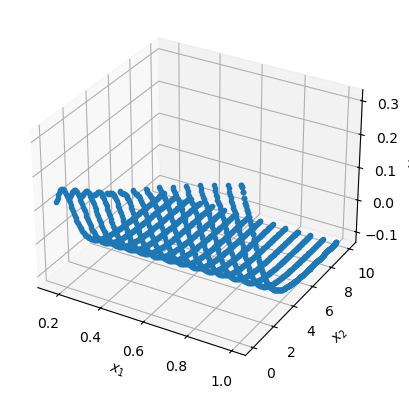

Training PINN for λ=0.0, η=0.0, Re=196
[OBS DEBUG] λ=0.0, η=0.0, Re=196
  X_obs shape: (100, 2)
  z range     : 0.0 → 10.0
  U min/max   : -1.0587911840678754e-22 → 0.18072177469730377
  V min/max   : -1.0 → 0.0
  W min/max   : -0.882598876953125 → 0.0
Compiling model...
'compile' took 0.000152 s

Training model...

Step      Train loss                                                                                                                                                Test loss                                                                                                                                                 Test metric
0         [5.52e-05, 5.30e-03, 5.41e-05, 7.68e-14, 2.18e-08, 1.15e-06, 6.38e-09, 2.15e-08, 8.28e-06, 5.95e-02, 8.91e-02, 1.11e-06, 9.30e-03, 1.09e+00, 3.11e-01]    [7.22e-05, 6.33e-03, 6.45e-05, 3.51e-14, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 9.30e-03, 1.09e+00, 3.11e-01]    []  
500       [3.43e-05, 5.80e-05

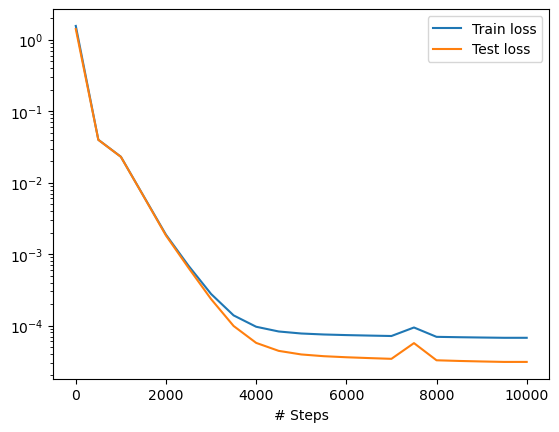

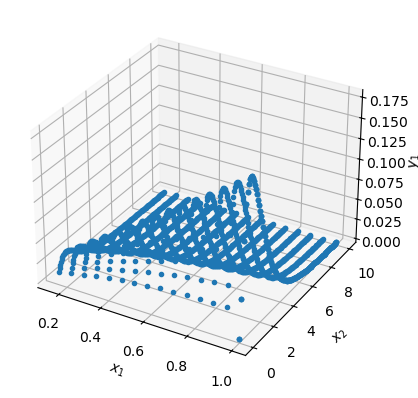

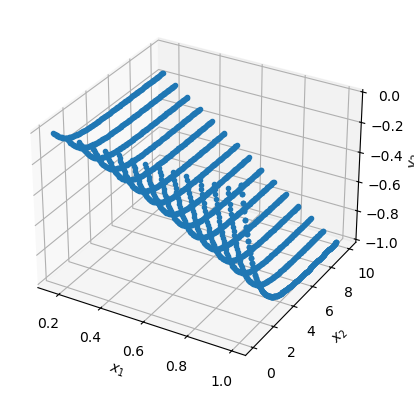

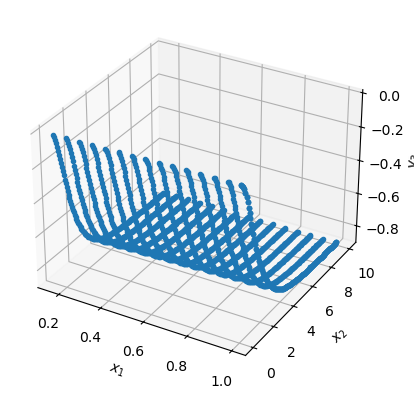

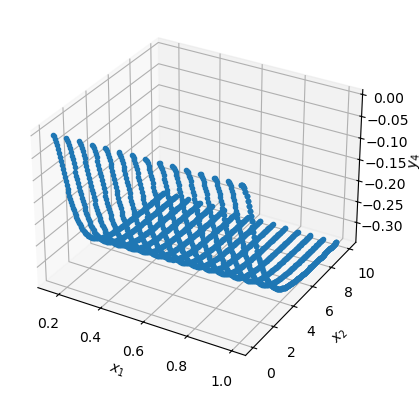

Training PINN for λ=0.0, η=0.0, Re=196
[OBS DEBUG] λ=0.0, η=0.0, Re=196
  X_obs shape: (100, 2)
  z range     : 0.0 → 10.0
  U min/max   : -1.0587911840678754e-22 → 0.18072177469730377
  V min/max   : -1.0 → 0.0
  W min/max   : -0.882598876953125 → 0.0
Compiling model...
'compile' took 0.000167 s

Training model...

Step      Train loss                                                                                                                                                Test loss                                                                                                                                                 Test metric
0         [8.35e-02, 1.38e-02, 4.43e-01, 4.26e-07, 7.93e-10, 9.07e-10, 2.76e-12, 9.00e-05, 5.98e-05, 6.44e-02, 1.18e-01, 1.25e-07, 4.55e+00, 3.96e+00, 1.02e-01]    [9.86e-02, 9.85e-03, 4.24e-01, 4.99e-07, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 4.55e+00, 3.96e+00, 1.02e-01]    []  
500       [1.12e-05, 6.09e-05

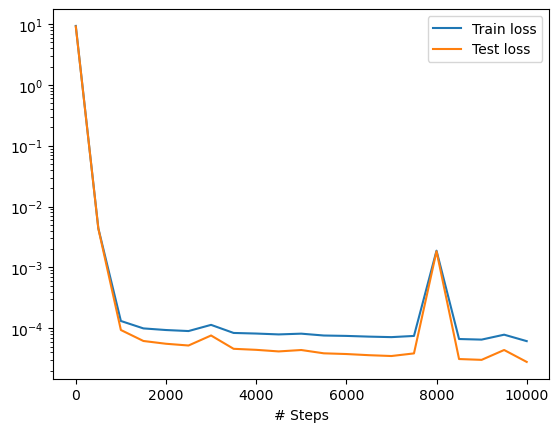

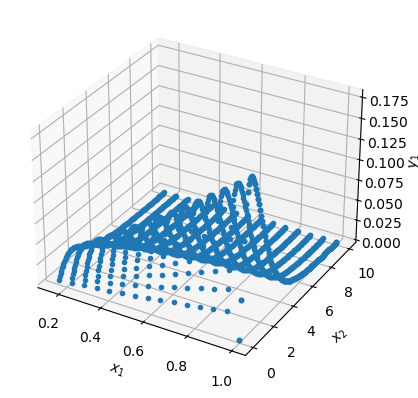

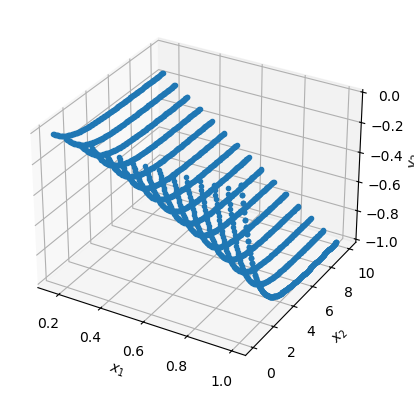

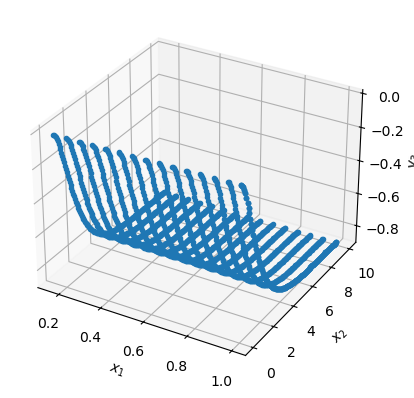

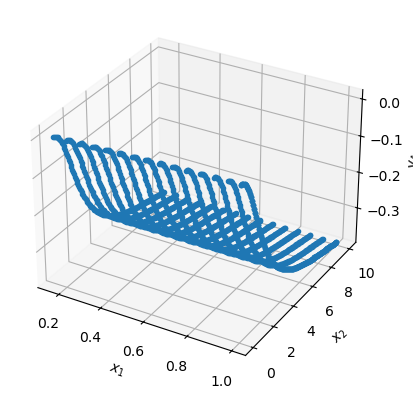

In [ ]:
import os
# ⚠ DDE_BACKEND must be set BEFORE importing deepxde
os.environ["DDE_BACKEND"] = "pytorch"

import numpy as np
import torch
import torch_directml
import deepxde as dde
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt


# =========================================
# 1) MW-von Kármán numerical solver
# =========================================

def vkd_ode(eta, y):
    """
    MW similarity ODE system:
      y[0] = F,  y[1] = F',  y[2] = G,  y[3] = G',  y[4] = H
    """
    f, fp, g, gp, h = y
    return np.vstack([
        fp,
        fp * h + f**2 - g**2,
        gp,
        gp * h + 2 * f * g,
        -2 * f,
    ])


def make_vkd_bc(lambda_slip=0.0, eta_slip=0.0, s_suction=0.0):
    """
    MW boundary conditions (in η-space):

      F(0) = λ F'(0)          -> f(0) - λ f'(0) = 0
      G(0) - 1 = η G'(0)      -> g(0) - 1 - η g'(0) = 0
      H(0) = -2 s             -> h(0) + 2 s = 0
      F(∞) = 0                -> f(η_max) = 0
      G(∞) = 0                -> g(η_max) = 0
    """
    def vkd_bc(ya, yb):
        f0, fp0, g0, gp0, h0 = ya
        fL, fpL, gL, gpL, hL = yb
        return np.array([
            f0 - lambda_slip * fp0,
            g0 - 1.0 - eta_slip * gp0,
            h0 + 2.0 * s_suction,
            fL,
            gL,
        ])
    return vkd_bc


def solve_vkd(lambda_slip, eta_slip,
              s_suction=0.0, eta_max=10.0, n_eta=400):
    """
    MW-von Kármán solution in similarity space for given (λ, η, s).
    """
    eta_mesh = np.linspace(0.0, eta_max, n_eta)
    y_guess = np.zeros((5, eta_mesh.size))
    y_guess[2, :] = 1.0        # G ~ 1
    y_guess[4, :] = -2.0 * s_suction

    bc = make_vkd_bc(lambda_slip=lambda_slip,
                     eta_slip=eta_slip,
                     s_suction=s_suction)
    sol = solve_bvp(vkd_ode, bc, eta_mesh, y_guess)
    if not sol.success:
        raise RuntimeError(
            f"VKD BVP solver did not converge for λ={lambda_slip}, η={eta_slip}: "
            + sol.message
        )
    return sol


def generate_obs_profiles_from_vk(Re, vk_sol, r_obs_list=None, L=10.0,
                                  n_z_obs=50):
    """
    Generate raw observation data for PINN from the MW similarity solution.

    Output:
      X_obs : (N,2)  -> [r, z]
      U_obs : (N,1)
      V_obs : (N,1)
      W_obs : (N,1)
      z_obs : (N,1)  (z-coordinates of all points)

    r_obs_list:
      - If None or a single float: generate data at a single radial location.
      - If a list/iterable: generate data for all r values in the list
        and stack everything vertically.
    """
    import numpy as np

    delta = Re ** (-0.5)

    # r list setting: default [0.1, 1.0]
    if r_obs_list is None:
        r_values = [0.1, 1.0]
    else:
        # If a single number is given, convert to list
        try:
            # test if iterable; handle strings separately
            iter(r_obs_list)
            if isinstance(r_obs_list, (float, int)):
                r_values = [float(r_obs_list)]
            else:
                r_values = list(r_obs_list)
        except TypeError:
            r_values = [float(r_obs_list)]

    # Uniformly spaced z points in physical space (common for all r)
    z_line = np.linspace(0.0, L, n_z_obs).reshape(-1, 1)   # (Nz,1)
    eta_obs = z_line.ravel()                               # (Nz,)

    # Evaluate MW solution at these η points
    eta_max_sol = vk_sol.x[-1]
    eta_clipped = np.minimum(eta_obs, eta_max_sol)
    y_vk = vk_sol.sol(eta_clipped)                         # (5, Nz)
    F = y_vk[0, :]                                         # (Nz,)
    G = y_vk[2, :]
    H = y_vk[4, :]

    X_list, U_list, V_list, W_list, z_list = [], [], [], [], []

    for r_obs in r_values:
        # Physical velocities
        U = r_obs * F
        V = r_obs * (G - 1.0)
        W = H

        # Input seen by the PINN: (r,z)
        X_r = np.hstack([r_obs * np.ones_like(z_line), z_line])  # (Nz,2)

        X_list.append(X_r.astype(np.float32))
        U_list.append(U.reshape(-1, 1).astype(np.float32))
        V_list.append(V.reshape(-1, 1).astype(np.float32))
        W_list.append(W.reshape(-1, 1).astype(np.float32))
        z_list.append(z_line.astype(np.float32))

    # Concatenate everything vertically
    X_obs = np.vstack(X_list)
    U_obs = np.vstack(U_list)
    V_obs = np.vstack(V_list)
    W_obs = np.vstack(W_list)
    z_obs = np.vstack(z_list)

    return X_obs, U_obs, V_obs, W_obs, z_obs



def debug_plot_vk_similarity(vk_sol, lambda_slip, eta_slip, outdir):
    """For debugging: similarity profiles F, G-1, H in η."""
    eta = vk_sol.x
    y_vk = vk_sol.sol(eta)
    F = y_vk[0, :]
    G = y_vk[2, :]
    H = y_vk[4, :]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
    axes[0].plot(eta, F)
    axes[0].set_xlabel(r"$\eta$")
    axes[0].set_ylabel(r"$F(\eta)$")
    axes[0].set_title("Similarity F(η)")

    axes[1].plot(eta, G - 1.0)
    axes[1].set_xlabel(r"$\eta$")
    axes[1].set_ylabel(r"$G(\eta)-1$")
    axes[1].set_title("Similarity G(η)-1")

    axes[2].plot(eta, H)
    axes[2].set_xlabel(r"$\eta$")
    axes[2].set_ylabel(r"$H(\eta)$")
    axes[2].set_title("Similarity H(η)")

    plt.tight_layout()
    fig.savefig(os.path.join(outdir,
                             f"vk_similarity_lambda{lambda_slip:g}_eta{eta_slip:g}.png"),
                dpi=200)
    plt.close(fig)



# =========================================
# 2) PINN part
# =========================================

device = torch_directml.device()
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

L = 10.0
r_min = 0.1
r_max = 1.0
geom = dde.geometry.Rectangle([r_min, 0.0], [r_max, L])

lambda_values = [0.0]
eta_values    = [0.0]
s_suction     = 0.0

Re_list = [196]

layer_sizes = [4]
neuron_sizes = 64


# ---------------------------
# Clenshaw–Curtis
# ---------------------------
def clenshaw_curtis_nodes_weights(N, a=-1.0, b=1.0):
    if N < 1:
        raise ValueError("N must be >= 1.")
    k = np.arange(0, N + 1)
    x = np.cos(np.pi * k / N)
    w = np.zeros(N + 1, dtype=float)
    if N % 2 == 0:
        m = np.arange(1, N // 2)
        v = np.zeros_like(k, dtype=float)
        for j in m:
            v += (np.cos(2 * j * np.pi * k / N) / (4 * j * j - 1.0))
        w = (2.0 / N) * (1.0 - v - (np.cos(np.pi * k) / (N * N - 1.0)))
    else:
        m = np.arange(1, (N + 1) // 2)
        v = np.zeros_like(k, dtype=float)
        for j in m:
            v += (np.cos(2 * j * np.pi * k / N) / (4 * j * j - 1.0))
        w = (2.0 / N) * (1.0 - v)
    xm = 0.5 * (a + b) + 0.5 * (b - a) * x
    wm = 0.5 * (b - a) * w
    return xm, wm


N_r, N_z = 32, 128
R_nodes, W_r = clenshaw_curtis_nodes_weights(N_r, a=r_min, b=r_max)
Z_nodes, W_z = clenshaw_curtis_nodes_weights(N_z, a=0.0,   b=L)

RR, ZZ = np.meshgrid(R_nodes, Z_nodes, indexing="xy")
Wr, Wz = np.meshgrid(W_r,     W_z,     indexing="xy")
W2D = (Wr * Wz).reshape(-1, 1)

domain_cc = np.column_stack([RR.reshape(-1), ZZ.reshape(-1)]).astype(np.float32)

R_nodes_t = torch.tensor(R_nodes, dtype=torch.float32, device=device).view(1, -1)
Z_nodes_t = torch.tensor(Z_nodes, dtype=torch.float32, device=device).view(1, -1)
W_r_t     = torch.tensor(W_r,     dtype=torch.float32, device=device).view(1, -1)
W_z_t     = torch.tensor(W_z,     dtype=torch.float32, device=device).view(1, -1)


def cc_weight_rz(r, z):
    dist_r = torch.abs(r - R_nodes_t)     # (B, Nr+1)
    idx_r  = torch.argmin(dist_r, dim=1, keepdim=True)
    dist_z = torch.abs(z - Z_nodes_t)
    idx_z  = torch.argmin(dist_z, dim=1, keepdim=True)
    w_r = torch.gather(W_r_t.repeat(r.shape[0], 1), 1, idx_r)
    w_z = torch.gather(W_z_t.repeat(z.shape[0], 1), 1, idx_z)
    return w_r * w_z  # (B,1)


# ---------------------------
# PDE + slip & far-field residual
# ---------------------------
def make_pde(Re, lambda_slip, eta_slip,
             u_z0_ref=None, v_z0_ref=None, w_L_ref=None,
             r_key=1.0):
    def pde(x, y):
        r = x[:, 0:1]
        z = x[:, 1:2]

        U = y[:, 0:1]
        V = y[:, 1:2]
        W = y[:, 2:3]
        P = y[:, 3:4]

        U_r = dde.grad.jacobian(y, x, i=0, j=0)
        U_z = dde.grad.jacobian(y, x, i=0, j=1)
        V_r = dde.grad.jacobian(y, x, i=1, j=0)
        V_z = dde.grad.jacobian(y, x, i=1, j=1)
        W_r = dde.grad.jacobian(y, x, i=2, j=0)
        W_z = dde.grad.jacobian(y, x, i=2, j=1)
        P_r = dde.grad.jacobian(y, x, i=3, j=0)
        P_z = dde.grad.jacobian(y, x, i=3, j=1)

        U_rr = dde.grad.jacobian(U_r, x, j=0)
        U_zz = dde.grad.jacobian(U_z, x, j=1)
        V_rr = dde.grad.jacobian(V_r, x, j=0)
        V_zz = dde.grad.jacobian(V_z, x, j=1)
        W_rr = dde.grad.jacobian(W_r, x, j=0)
        W_zz = dde.grad.jacobian(W_z, x, j=1)

        # Rotating-disk PDE (unchanged)
        eq1 = (1.0 / r) * (U + r * U_r) + W_z
        eq2 = U * U_r + W * U_z - (V + r) ** 2 / r - (1.0 / Re) * (U_zz + (1.0 / r) * U_r + U_rr - U / (r ** 2)) + P_r
        #eq2 = U * U_r + W * U_z - V**2 / r - (1.0 / Re) * (U_zz + (1.0 / r) * U_r + U_rr - U / (r ** 2))
        eq3 = U * V_r + W * V_z + (U * V) / r + 2.0 * U - (1.0 / Re) * (V_zz + (1.0 / r) * V_r + V_rr - V / (r ** 2))
        #eq3 = U * V_r + W * V_z + (U * V) / r  - (1.0 / Re) * (V_zz + (1.0 / r) * V_r + V_rr - V / (r ** 2))
        eq4 = U * W_r + W * W_z + P_z - (1.0 / Re) * ((1.0 / r) * W_r + W_rr + W_zz)

        # Clenshaw–Curtis weight (for PDE part)
        w_cc = cc_weight_rz(r, z)
        s = torch.sqrt(torch.clamp(w_cc, min=1e-30))

        # --- Slip BC (z=0): U = λ U_z, V = η V_z, W=0 ---
        mask_bottom = (torch.abs(z) < 1e-20).float()
        eq5 = mask_bottom * (U - lambda_slip * U_z)
        eq6 = mask_bottom * (V - eta_slip * V_z)
        eq7 = mask_bottom * W

        # --- Far field (z=L): U=0, V=-r, W=0 ---
        mask_top = (torch.abs(z - L) < 1e-20).float()
        eq8  = mask_top * U
        eq9  = mask_top * (V + r)
        # Far-field for W if desired:
        # eq10 = mask_top * W

        residuals = [
            s * eq1, s * eq2, s * eq3, s * eq4,
            s * eq5, s * eq6, s * eq7, s * eq8, s * eq9,
        ]

        # r ≈ r_key mask
        mask_rkey = (torch.abs(r - r_key) < 1e-6).float()

        # penalty for u_z(0) and v_z(0): z=0 and r=r_key
        if (u_z0_ref is not None) and (v_z0_ref is not None):
            mask_bottom_rkey = mask_bottom * mask_rkey
            eq10 = 10*mask_bottom_rkey * (U_z - u_z0_ref)
            eq11 = 10*mask_bottom_rkey * (V_z - v_z0_ref)
            residuals.append(eq10)
            residuals.append(eq11)

        # penalty for w(L): z=L and r=r_key
        if w_L_ref is not None:
            mask_top_rkey = mask_top * mask_rkey
            eq12 = mask_top_rkey * (W - w_L_ref)
            residuals.append(s * eq12)

        return residuals

    return pde


# =========================================
# 3) Training loop
# =========================================

base_dir = "Outputs_PINN_MW_lambda_eta_sweep_196"
os.makedirs(base_dir, exist_ok=True)

for lambda_slip in lambda_values:
    for eta_slip in eta_values:

        print(f"\n=== MW BVP: λ={lambda_slip}, η={eta_slip} is being solved ===")
        vk_sol = solve_vkd(lambda_slip=lambda_slip,
                           eta_slip=eta_slip,
                           s_suction=s_suction,
                           eta_max=10.0,
                           n_eta=400)

        slip_dir = os.path.join(
            base_dir, f"VK_ref_lambda{lambda_slip:g}_eta{eta_slip:g}_Re196_64x4_sigmoid"
        )
        os.makedirs(slip_dir, exist_ok=True)

        # Save similarity profiles (in η) if desired
        debug_plot_vk_similarity(vk_sol, lambda_slip, eta_slip, slip_dir)
        activation_funcs = ["tanh", "Sigmoid", "Swish"]

        for Re in Re_list:
            for l in layer_sizes:
                for act in activation_funcs:

                    print(f"Training PINN for λ={lambda_slip}, η={eta_slip}, Re={Re}")

                    vk_sol = solve_vkd(
                        lambda_slip=lambda_slip,
                        eta_slip=eta_slip,
                        s_suction=0.0,
                        eta_max=10.0,
                        n_eta=400,
                    )

                    # --- Critical parameters from MW solution ---
                    y0 = vk_sol.sol(0.0)
                    f0, fp0, g0, gp0, h0 = y0

                    # For r = 1:
                    # u(r=1,z) = F(eta)  -> u_z(0) = F'(0) = fp0
                    # v(r=1,z) = G(eta)-1 -> v_z(0) = G'(0) = gp0
                    u_z0_ref = float(fp0)
                    v_z0_ref = float(gp0)

                    # Far field: for z = L, eta = min(L, eta_max)
                    eta_L = min(L, vk_sol.x[-1])
                    yL = vk_sol.sol(eta_L)
                    hL = yL[4]
                    w_L_ref = float(hL)


                    pde = make_pde(
                                    Re,
                                    lambda_slip,
                                    eta_slip,
                                    u_z0_ref=u_z0_ref,
                                    v_z0_ref=v_z0_ref,
                                    w_L_ref=w_L_ref,
                                    r_key=1.0,   # line r=1
                                )

                    # ---- Raw obs data from MW solution (only over z) ----
                    X_obs, U_obs, V_obs, W_obs, z_obs = generate_obs_profiles_from_vk(
                        Re=Re,
                        vk_sol=vk_sol,
                        r_obs_list=[1.0],
                        L=L,
                        n_z_obs=100,
                    )

                    print(f"[OBS DEBUG] λ={lambda_slip}, η={eta_slip}, Re={Re}")
                    print("  X_obs shape:", X_obs.shape)
                    print("  z range     :", float(z_obs.min()), "→", float(z_obs.max()))
                    print("  U min/max   :", float(U_obs.min()), "→", float(U_obs.max()))
                    print("  V min/max   :", float(V_obs.min()), "→", float(V_obs.max()))
                    print("  W min/max   :", float(W_obs.min()), "→", float(W_obs.max()))

                    # U, V, W profiles over z (for inspection)
                    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
                    axes[0].plot(z_obs, U_obs[:, 0])
                    axes[0].set_xlabel("z")
                    axes[0].set_ylabel("U(r=1,z)")
                    axes[0].set_title("Numerical U profile")

                    axes[1].plot(z_obs, V_obs[:, 0])
                    axes[1].set_xlabel("z")
                    axes[1].set_ylabel("V(r=1,z)")
                    axes[1].set_title("Numerical V profile")

                    axes[2].plot(z_obs, W_obs[:, 0])
                    axes[2].set_xlabel("z")
                    axes[2].set_ylabel("W(r=1,z)")
                    axes[2].set_title("Numerical W profile")

                    plt.tight_layout()
                    fig.savefig(os.path.join(
                        slip_dir,
                        f"vk_obs_profiles_z_lambda{lambda_slip:g}_eta{eta_slip:g}_Re{int(Re)}.png"
                    ), dpi=200)
                    plt.close(fig)

                    # PointSetBC: the only data given to the PINN is this raw (r,z) + U,V,W data
                    bc_U = dde.icbc.PointSetBC(X_obs, U_obs, component=0)
                    bc_V = dde.icbc.PointSetBC(X_obs, V_obs, component=1)
                    bc_W = dde.icbc.PointSetBC(X_obs, W_obs, component=2)
                    bcs = [bc_U, bc_V, bc_W]

                    # Data (anchors=CC + obs BC)
                    data = dde.data.PDE(
                        geom, pde, bcs,
                        num_domain=0,
                        num_boundary=0,
                        num_test=2000,
                        anchors=domain_cc,
                    )

                    delta = Re ** (-0.5)

                    # --- Feature/output transforms---
                    def feature_transform(x):
                        r = x[:, 0:1]
                        z = x[:, 1:2]
                        eta = z / delta    # only for the network input
                        return torch.cat([r, eta], dim=1)

                    layers = [2] + [64] * l + [4]
                    net = dde.nn.FNN(layers, act, "Glorot uniform")
                    net.apply_feature_transform(feature_transform)

                    def output_transform(x, y):
                        r = x[:, 0:1]
                        U = r*y[:, 0:1]
                        V = r*y[:, 1:2]
                        W = delta * y[:, 2:3]
                        P = (delta ** 2) * y[:, 3:4]
                        return torch.cat([U, V, W, P], dim=1)

                    net.apply_output_transform(output_transform)
                    net.to(device)

                    output_dir = os.path.join(
                        base_dir,
                        f"MW_lambda{lambda_slip:g}_eta{eta_slip:g}_Re{int(Re)}_64x{l}_{act}"
                    )
                    os.makedirs(output_dir, exist_ok=True)
                    lambda_data = 0.5
                    key_weight = 10.0
                    loss_weights = [1.0] * 9 + [key_weight] * 3 + [lambda_data] * 3

                    model = dde.Model(data, net)
                    model.compile("adam", lr=5e-4, loss_weights=loss_weights)

                    losshistory_adam, train_state_adam = model.train(
                        iterations=10000,
                        model_save_path=os.path.join(output_dir, "model_adam"),
                        verbose=1,
                        display_every=500,
                    )
                    dde.saveplot(
                        losshistory_adam, train_state_adam,
                        issave=True, isplot=True, output_dir=output_dir
                    )


[UYARI] Outputs_PINN_MW_lambda_eta_sweep_dif-activations\MW_lambda0_eta0_Re196_64x4_Sin\loss.dat bulunamadı, atlanıyor.
Grafikler kaydedildi: Outputs_PINN_MW_lambda_eta_sweep_dif-activations\loss_PDE_BC_all_acts_lambda0_eta0_Re196_64x4.png ve Outputs_PINN_MW_lambda_eta_sweep_dif-activations\loss_PDE_BC_all_acts_lambda0_eta0_Re196_64x4.pdf


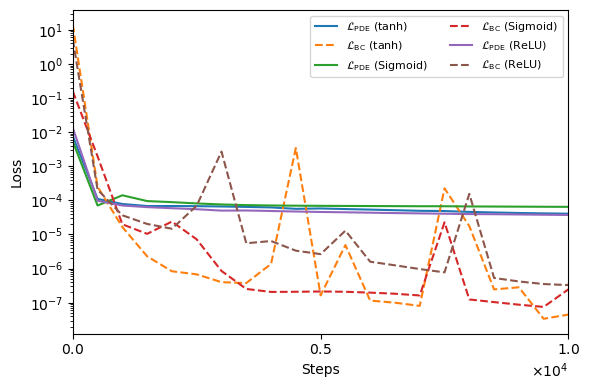

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MultipleLocator

# -------------------------------------------------
# Folder / parameter definitions
# -------------------------------------------------
base_dir    = "Outputs_PINN_MW_lambda_eta_sweep_dif-activations"
lambda_slip = 0.0     
eta_slip    = 0.0    
Re          = 196.0
l           = 4       # 64x4

acts = ["tanh", "Sigmoid", "Sin", "ReLU"]

# -------------------------------------------------
# Common figure: L_PDE and L_BC for all activations
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

for act in acts:
    output_dir = os.path.join(
        base_dir,
        f"MW_lambda{lambda_slip:g}_eta{eta_slip:g}_Re{int(Re)}_64x{l}_{act}"
    )
    train_path = os.path.join(output_dir, "loss.dat")

    if not os.path.exists(train_path):
        print(f"[WARNING] {train_path} not found, skipping.")
        continue

    loss_data = np.loadtxt(train_path)

    # DeepXDE train.dat format: step, total_loss, comp_1, comp_2, ...
    steps = loss_data[:, 0]
    comps = loss_data[:, 2:]   # take components after total loss

    # --- indices ---
    # PDE: 4 components, BC: 5 components, Data: 3 components (total 12)
    idx_pde = slice(0, 4)    # 0,1,2,3
    idx_bc  = slice(7, 12)   # 7,8,9,10,11

    pde_loss = np.sum(comps[:, idx_pde], axis=1)
    bc_loss  = np.sum(comps[:, idx_bc],  axis=1)

    ax.semilogy(steps, pde_loss,
                label=rf"$\mathcal{{L}}_{{\mathrm{{PDE}}}}$ ({act})")
    ax.semilogy(steps, bc_loss, linestyle="--",
                label=rf"$\mathcal{{L}}_{{\mathrm{{BC}}}}$ ({act})")

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))        
ax.xaxis.set_major_formatter(formatter)

# Major ticks at 0, 5000, 10000, 15000, 20000
ax.xaxis.set_major_locator(MultipleLocator(5000))
ax.set_xlim(0, 10000)

ax.set_xlabel("Steps")
ax.set_ylabel("Loss")
ax.legend(fontsize=8, ncol=2)
fig.tight_layout()

# Save figure under base_dir
fig_png = os.path.join(
    base_dir,
    f"loss_PDE_BC_all_acts_lambda{lambda_slip:g}_eta{eta_slip:g}_Re{int(Re)}_64x{l}.png"
)
fig_pdf = fig_png.replace(".png", ".pdf")

fig.savefig(fig_png, dpi=200)
fig.savefig(fig_pdf, dpi=200)

print("Figures saved:", fig_png, "and", fig_pdf)


λ=0.0: checkpoint yükleniyor -> Outputs_PINN_MW_lambda_eta_sweep_196\MW_lambda0_eta0_Re196_64x4\model_adam-2000.pt


C:\Users\Serkan\AppData\Local\Temp\ipykernel_15072\2640538835.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)
C:\Use

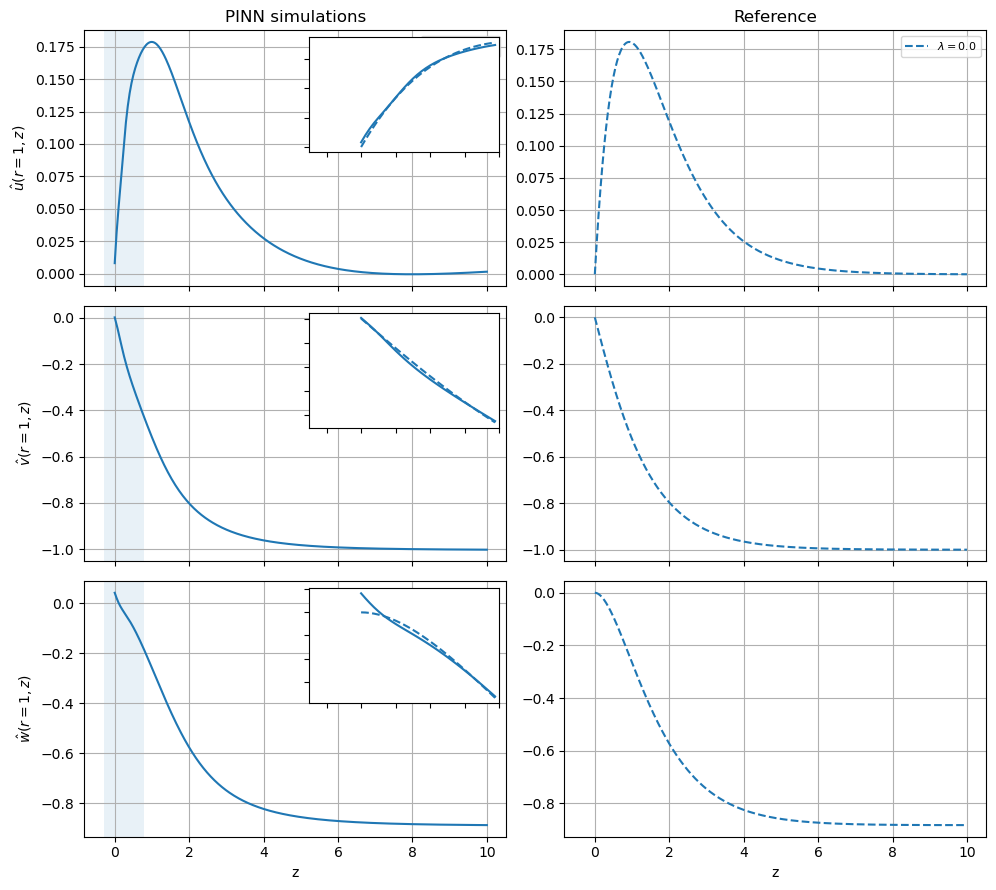

Zoom’lu (tüm λ) PINN + Referans profil figürü kaydedildi: Outputs_PINN_MW_lambda_eta_sweep_196\PINN_vs_Ref_profiles_r1_all_lambda_zoom_all.png
E_U = 0.11519392 E_V = 0.009377154 E_W = 0.044723343 E_comb = 0.071548924

--- Önemli parametreler (MW vs PINN, r=1) ---
u_z(0): ref = 0.46152356, PINN = 0.50887805, E_relL2 = 1.0260e-01
v_z(0): ref = -0.66676988, PINN = -0.61586928, E_relL2 = 7.6339e-02
w(L):   ref = -0.90878978, PINN = -0.88645047, E_relL2 = 2.4581e-02
Combined key-param error (u_z(0), v_z(0), w(L)): 5.9954e-02


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch_directml
import deepxde as dde
from scipy.integrate import solve_bvp

# -------------------------------------------------
# Environment / parameters
# -------------------------------------------------
os.environ["DDE_BACKEND"] = "pytorch"

device = torch_directml.device()
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

L = 10.0
r_min, r_max = 0.1, 1.0
Re = 196.0
delta = Re ** (-0.5)

lambda_values = [0.0]
eta_values = [0.0]   # constant
neu = 64
l = 4

base_dir = "Outputs_PINN_MW_lambda_eta_sweep_196" 

# =================================================
# 1) MW-von Kármán numerical solver (for reference)
# =================================================
def vkd_ode(eta, y):
    f, fp, g, gp, h = y
    return np.vstack([
        fp,
        fp*h + f**2 - g**2,
        gp,
        gp*h + 2*f*g,
        -2*f
    ])

def make_vkd_bc(lambda_slip=0.0, eta_slip=0.0, s_suction=0.0):
    def vkd_bc(ya, yb):
        f0, fp0, g0, gp0, h0 = ya
        fL, fpL, gL, gpL, hL = yb
        return np.array([
            f0 - lambda_slip * fp0,
            g0 - 1.0 - eta_slip * gp0,
            h0 + 2.0 * s_suction,
            fL,
            gL
        ])
    return vkd_bc

def solve_vkd(lambda_slip, eta_slip, s_suction=0.0, eta_max=10.0, n_eta=400):
    eta_mesh = np.linspace(0.0, eta_max, n_eta)
    y_guess = np.zeros((5, eta_mesh.size))
    y_guess[2, :] = 1.0
    y_guess[4, :] = -2.0 * s_suction

    bc = make_vkd_bc(lambda_slip=lambda_slip,
                     eta_slip=eta_slip,
                     s_suction=s_suction)
    sol = solve_bvp(vkd_ode, bc, eta_mesh, y_guess)
    if not sol.success:
        raise RuntimeError(
            f"VKD BVP solver did not converge for λ={lambda_slip}, η={eta_slip}: "
            + sol.message
        )
    return sol

# -------------------------------------------------
# 2) Network architecture
# -------------------------------------------------
def build_net():
    layers = [2] + [neu] * l + [4]
    net = dde.nn.FNN(layers, "tanh", "Glorot uniform")

    def feature_transform(x):
        # x: (N,2) torch tensor
        r = x[:, 0:1]
        z = x[:, 1:2]
        eta = z / delta
        return torch.cat([r, eta], dim=1)
    
    def output_transform(x, y):
        r = x[:, 0:1]
        U = r * y[:, 0:1]
        V = r * y[:, 1:2]
        W = delta * y[:, 2:3]
        P = (delta ** 2) * y[:, 3:4]
        return torch.cat([U, V, W, P], dim=1)

    net.apply_feature_transform(feature_transform)
    net.apply_output_transform(output_transform)
    net.to(device)
    return net

# -------------------------------------------------
# 3) Evaluation grid (r=1 line, z∈[0,L])
# -------------------------------------------------
n_plot = 400
z_eval = np.linspace(0.0, L, n_plot, dtype=np.float32).reshape(-1, 1)
r_eval = np.ones_like(z_eval, dtype=np.float32)
X_eval = np.hstack([r_eval, z_eval])  # (N,2)

# Dictionaries that will retain the results
U_all, V_all, W_all = {}, {}, {}          # PINN
U_ref_all, V_ref_all, W_ref_all = {}, {}, {}  # Reference

colors = ["C0", "C1", "C2", "C3", "C4"]



def generate_obs_profiles_from_vk(Re, vk_sol, r_obs_list=None, L=10.0,
                                  n_z_obs=50):
    """
    Generate raw observation data for PINN from MW similarity solution.

    Outputs:
      X_obs : (N,2)  -> [r, z]
      U_obs : (N,1)
      V_obs : (N,1)
      W_obs : (N,1)
      z_obs : (N,1)  (all points' z coordinates)

    r_obs_list:
      - If None or a single float is given: generate data from a single radial point.
      - If a list/iterable is given: generate data for all r values in the list
        and stack them vertically.
    """
    import numpy as np

    delta = Re ** (-0.5)

    # r list setting: default is [0.1, 1.0]
    if r_obs_list is None:
        r_values = [0.1, 1.0]
    else:
        # Convert single number to list
        try:
            # Test if iterable; treat string separately
            iter(r_obs_list)
            if isinstance(r_obs_list, (float, int)):
                r_values = [float(r_obs_list)]
            else:
                r_values = list(r_obs_list)
        except TypeError:
            r_values = [float(r_obs_list)]

    # Equally spaced z points in physical space (common for all r)
    z_line = np.linspace(0.0, L, n_z_obs).reshape(-1, 1)   # (Nz,1)
    eta_obs = z_line.ravel()                               # (Nz,)

    # Evaluate MW solution at these η points
    eta_max_sol = vk_sol.x[-1]
    eta_clipped = np.minimum(eta_obs, eta_max_sol)
    y_vk = vk_sol.sol(eta_clipped)                         # (5, Nz)
    F = y_vk[0, :]                                         # (Nz,)
    G = y_vk[2, :]
    H = y_vk[4, :]

    X_list, U_list, V_list, W_list, z_list = [], [], [], [], []

    for r_obs in r_values:
        # Physical velocities
        U = r_obs * F
        V = r_obs * (G - 1.0)
        W = H

        # PINN input: (r,z)
        X_r = np.hstack([r_obs * np.ones_like(z_line), z_line])  # (Nz,2)

        X_list.append(X_r.astype(np.float32))
        U_list.append(U.reshape(-1, 1).astype(np.float32))
        V_list.append(V.reshape(-1, 1).astype(np.float32))
        W_list.append(W.reshape(-1, 1).astype(np.float32))
        z_list.append(z_line.astype(np.float32))

    # Stack all vertically
    X_obs = np.vstack(X_list)
    U_obs = np.vstack(U_list)
    V_obs = np.vstack(V_list)
    W_obs = np.vstack(W_list)
    z_obs = np.vstack(z_list)

    return X_obs, U_obs, V_obs, W_obs, z_obs

# -------------------------------------------------
# 4) For each lambda: PINN output and reference profiles
# -------------------------------------------------
for lam in lambda_values:
    for eta in eta_values:
        # ----- PINN -----
        run_dir = os.path.join(
            base_dir,
            f"MW_lambda{lam:g}_eta{eta:g}_Re{int(Re)}_{neu}x{l}"
        )

        ckpts = sorted(glob.glob(os.path.join(run_dir, "model_adam-*")))
        if not ckpts:
            print(f"[UYARI] Checkpoint bulunamadı: {run_dir}")
            continue

        ckpt_path = ckpts[-1]  # last saved
        print(f"λ={lam}: loading checkpoint -> {ckpt_path}")

        net = build_net()
        state = torch.load(ckpt_path, map_location=device)

        if isinstance(state, dict) and "model_state_dict" in state:
            net.load_state_dict(state["model_state_dict"])
        else:
            net.load_state_dict(state)

        net.eval()

        with torch.no_grad():
            x_t = torch.tensor(X_eval, dtype=torch.float32, device=device)
            y_t = net(x_t)                 # physical [U,V,W,P] after output_transform
            y_pred = y_t.cpu().numpy()     # (N,4)

        U_all[lam] = y_pred[:, 0]
        V_all[lam] = y_pred[:, 1]
        W_all[lam] = y_pred[:, 2]

        # ----- Reference side (MW-vK) -----
        vk_sol = solve_vkd(lambda_slip=lam,
                        eta_slip=eta,
                        s_suction=0.0,
                        eta_max=10.0,
                        n_eta=400)

        eta_vals = (z_eval.flatten())
        eta_clipped = np.minimum(eta_vals, vk_sol.x[-1])
        y_vk = vk_sol.sol(eta_clipped)   # (5, N)

        F = y_vk[0, :]
        G = y_vk[2, :]
        H = y_vk[4, :]

        U_ref_all[lam] = (1.0 * F)                    # r=1
        V_ref_all[lam] = (1.0 * (G - 1.0))
        W_ref_all[lam] = (H)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# -------------------------------------------------
# 5) Common U,V,W plots (stacked) + zoom inset for ALL λ
# -------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(10, 9), sharex=True)

z_plot = z_eval.flatten()

# Zoomed z range
z0, z1 = -0.3, 0.8 

# --- U row ---
for lam, color in zip(lambda_values, colors):
    if lam not in U_all or lam not in U_ref_all:
        continue
    label = rf"$\lambda={lam}$"
    axes[0, 0].plot(z_plot, U_all[lam], color=color, label=label)
    axes[0, 1].plot(z_plot, U_ref_all[lam], color=color, linestyle="--", label=label)

axes[0, 0].set_ylabel(r"$\hat{u}(r=1,z)$")
axes[0, 0].set_title(r"PINN simulations")
axes[0, 1].set_title("Reference")

# --- V row ---
for lam, color in zip(lambda_values, colors):
    if lam not in V_all or lam not in V_ref_all:
        continue
    label = rf"$\lambda={lam}$"
    axes[1, 0].plot(z_plot, V_all[lam], color=color, label=label)
    axes[1, 1].plot(z_plot, V_ref_all[lam], color=color, linestyle="--", label=label)

axes[1, 0].set_ylabel(r"$\hat{v}(r=1,z)$")


# --- W row ---
for lam, color in zip(lambda_values, colors):
    if lam not in W_all or lam not in W_ref_all:
        continue
    label = rf"$\lambda={lam}$"
    axes[2, 0].plot(z_plot, W_all[lam], color=color, label=label)
    axes[2, 1].plot(z_plot, W_ref_all[lam], color=color, linestyle="--", label=label)

axes[2, 0].set_ylabel(r"$\hat{w}(r=1,z)$")
axes[2, 0].set_xlabel("z")
axes[2, 1].set_xlabel("z")


# -------------------------------------------------
# Zoom insets: for each row, ALL λ's on top of each other
# -------------------------------------------------
for row, (U_dict, V_dict, W_dict, Uref_dict, Vref_dict, Wref_dict) in enumerate(
    [(U_all, V_all, W_all, U_ref_all, V_ref_all, W_ref_all)]
):
    pass

# U için inset
ax_main = axes[0, 0]
ax_main.axvspan(z0, z1, alpha=0.1)
ax_inset_U = inset_axes(ax_main, width="45%", height="45%", loc="upper right")
ax_inset_U.set_xticklabels([])
ax_inset_U.set_yticklabels([])
mask = (z_plot >= z0) & (z_plot <= z1)
for lam, color in zip(lambda_values, colors):
    if lam not in U_all or lam not in U_ref_all:
        continue
    ax_inset_U.plot(z_plot[mask], U_all[lam][mask], color=color)
    ax_inset_U.plot(z_plot[mask], U_ref_all[lam][mask], color=color, linestyle="--")
ax_inset_U.set_xlim(z0, z1)
ax_inset_U.tick_params(labelsize=7)
#ax_inset_U.set_title("zoom", fontsize=8)

# V için inset
ax_main = axes[1, 0]
ax_main.axvspan(z0, z1, alpha=0.1)
ax_inset_V = inset_axes(ax_main, width="45%", height="45%", loc="upper right")
ax_inset_V.set_xticklabels([])
ax_inset_V.set_yticklabels([])
for lam, color in zip(lambda_values, colors):
    if lam not in V_all or lam not in V_ref_all:
        continue
    ax_inset_V.plot(z_plot[mask], V_all[lam][mask], color=color)
    ax_inset_V.plot(z_plot[mask], V_ref_all[lam][mask], color=color, linestyle="--")
ax_inset_V.set_xlim(z0, z1)
ax_inset_V.tick_params(labelsize=7)
#ax_inset_V.set_title("zoom", fontsize=8)
# W için inset
ax_main = axes[2, 0]
ax_main.axvspan(z0, z1, alpha=0.1)
ax_inset_W = inset_axes(ax_main, width="45%", height="45%", loc="upper right")
ax_inset_W.set_xticklabels([])
ax_inset_W.set_yticklabels([])
for lam, color in zip(lambda_values, colors):
    if lam not in W_all or lam not in W_ref_all:
        continue
    ax_inset_W.plot(z_plot[mask], W_all[lam][mask], color=color)
    ax_inset_W.plot(z_plot[mask], W_ref_all[lam][mask], color=color, linestyle="--")
ax_inset_W.set_xlim(z0, z1)
ax_inset_W.tick_params(labelsize=7)
#ax_inset_W.set_title("zoom", fontsize=8)
# Grid + legend
for i in range(3):
    for j in range(2):
        axes[i, j].grid(True)

axes[0, 0].legend(loc="best", fontsize=8)
axes[0, 1].legend(loc="best", fontsize=8)

plt.tight_layout()
out_fig = os.path.join(base_dir, "PINN_vs_Ref_profiles_r1_all_lambda_zoom_all.png")
out_fig2 = os.path.join(base_dir, "PINN_vs_Ref_profiles_r1_all_lambda_zoom_all.pdf")

plt.savefig(out_fig, dpi=200); plt.savefig(out_fig2, dpi=200)
plt.show()

print("Zoomed (all λ) PINN + Reference profile figure saved:", out_fig)




def rel_L2(pred, ref):
    """Relative L2 norm"""
    num = np.sum((pred - ref)**2)
    den = np.sum(ref**2) + 1e-16
    return np.sqrt(num / den)


def compute_relL2_at_r_MW(
    net,
    Re,
    vk_sol,
    r_eval=1.0,
    L=10.0,
    n_z_obs=400,
    device=None,
):
    """
    For the MW (smooth disk) similarity solution, it calculates 
    the relative L2 error between the PINN and reference profiles at the given r coordinate.

    Input:
      net      : Trained PINN network (with feature/output transform applied).
      Re       : Reynolds number (should be the same as used for feature/output transform).
      vk_sol   : Output of solve_vkd(...) (MW similarity solution).
      r_eval   : Radial location at which the error is computed (e.g., 0.1 or 1.0).
      L        : Physical upper limit in z.
      n_z_obs  : Number of grid points to use in the z direction.
      device   : Torch device (if None, uses net's own device).
    Output:
      (E_U, E_V, E_W, E_combined)

      E_combined = sqrt( (E_U^2 + E_V^2 + E_W^2) / 3 )
    """
    if device is None:
        device = next(net.parameters()).device

    # ---- Referans (MW) profilleri: r = r_eval ----
    X_ref, U_ref, V_ref, W_ref, z_ref = generate_obs_profiles_from_vk(
        Re=Re,
        vk_sol=vk_sol,
        r_obs_list=[r_eval],  
        L=L,
        n_z_obs=n_z_obs,
    )
    U_ref = U_ref[:, 0]
    V_ref = V_ref[:, 0]
    W_ref = W_ref[:, 0]


    # ---- PINN output at the same (r,z) points ----
    with torch.no_grad():
        x_t = torch.tensor(X_ref, dtype=torch.float32, device=device)
        y_t = net(x_t)          # after output_transform [U,V,W,P]
        y_pred = y_t.cpu().numpy()

    U_p = y_pred[:, 0]
    V_p = y_pred[:, 1]
    W_p = y_pred[:, 2]

    # ---- Relative L2 errors ----
    E_U = rel_L2(U_p, U_ref)
    E_V = rel_L2(V_p, V_ref)
    E_W = rel_L2(W_p, W_ref)
    E_comb = np.sqrt((E_U**2 + E_V**2 + E_W**2) / 3.0)

    return E_U, E_V, E_W, E_comb

vk_sol = solve_vkd(lambda_slip=0.1, eta_slip=0.0, s_suction=0.0,
                   eta_max=10.0, n_eta=400)

E_U, E_V, E_W, E_tot = compute_relL2_at_r_MW(
    net=net,      # trained PINN
    Re=196.0,
    vk_sol=vk_sol,
    r_eval=1.0,   
    L=10.0,
    n_z_obs=200,
)

print("E_U =", E_U, "E_V =", E_V, "E_W =", E_W, "E_comb =", E_tot)

def compute_keyparam_relL2_MW(
    net,
    Re,
    vk_sol,
    r_eval=1.0,
    L=10.0,
    device=None,
):
    """
    Key parameters obtained from the MW similarity solution:
      - u_z(0)  (du/dz at the wall)
      - v_z(0)  (dv/dz at the wall)
      - w(L)    (far-field axial velocity at z = L)

    These parameters are computed from both the reference (MW) and the PINN and
    return relative L2 errors.
    """
    if device is None:
        device = next(net.parameters()).device

    # -------------------------
    # Reference (MW)
    # -------------------------
    # y = [f, f', g, g', h]
    y0 = vk_sol.sol(0.0)
    f0, fp0, g0, gp0, h0 = y0

    # r=1 için:
    # u(r=1,z) = F(eta) -> u_z(0) = F'(0) 
    # v(r=1,z) = G(eta) - 1 -> v_z(0) = G'(0)
    u_z0_ref = fp0
    v_z0_ref = gp0

    # Far-field: eta = min(L, eta_max) for z = L
    eta_L = min(L, vk_sol.x[-1])
    yL = vk_sol.sol(eta_L)
    hL = yL[4]
    w_L_ref = hL  # w(r,z) = H(eta)

    # -------------------------
    # PINN
    # -------------------------
    net.eval()
    with torch.enable_grad():
        # Derivatives at the wall point (r = r_eval, z = 0)
        x_wall = torch.tensor(
            [[r_eval, 0.0]],
            dtype=torch.float32,
            device=device,
            requires_grad=True,
        )
        y_wall = net(x_wall)  # [U,V,W,P]
        U_wall = y_wall[:, 0:1]
        V_wall = y_wall[:, 1:2]

        # dU/dz and dV/dz (input: x = [r,z], z is the 2nd component)
        gradU = torch.autograd.grad(
            U_wall, x_wall,
            torch.ones_like(U_wall),
            retain_graph=True,
        )[0]
        gradV = torch.autograd.grad(
            V_wall, x_wall,
            torch.ones_like(V_wall),
        )[0]

        u_z0_pred = gradU[0, 1].item()  # dU/dz
        v_z0_pred = gradV[0, 1].item()  # dV/dz

        # Far-field axial velocity: w(r_eval, z=L)
        x_far = torch.tensor(
            [[r_eval, L]],
            dtype=torch.float32,
            device=device,
            requires_grad=False,
        )
        y_far = net(x_far)
        w_L_pred = y_far[0, 2].item()  # W component

    # -------------------------
    # Relative L2 errors
    # -------------------------
    E_u_z0 = rel_L2(
        np.array([u_z0_pred], dtype=np.float64),
        np.array([u_z0_ref], dtype=np.float64),
    )
    E_v_z0 = rel_L2(
        np.array([v_z0_pred], dtype=np.float64),
        np.array([v_z0_ref], dtype=np.float64),
    )
    E_w_L = rel_L2(
        np.array([w_L_pred], dtype=np.float64),
        np.array([w_L_ref], dtype=np.float64),
    )

    # Measure the three key parameters as a single vector as well:
    E_comb_key = rel_L2(
        np.array([u_z0_pred, v_z0_pred, w_L_pred], dtype=np.float64),
        np.array([u_z0_ref,  v_z0_ref,  w_L_ref],  dtype=np.float64),
    )

    return {
        "u_z0_ref": u_z0_ref,
        "u_z0_pred": u_z0_pred,
        "v_z0_ref": v_z0_ref,
        "v_z0_pred": v_z0_pred,
        "w_L_ref":  w_L_ref,
        "w_L_pred": w_L_pred,
        "E_u_z0": E_u_z0,
        "E_v_z0": E_v_z0,
        "E_w_L":  E_w_L,
        "E_comb_key": E_comb_key,
    }

# -----------------------------------------
# Relative L2 error for key parameters
# u_z(0), v_z(0), w(L)
# -----------------------------------------
key_err = compute_keyparam_relL2_MW(
    net=net,
    Re=Re,
    vk_sol=vk_sol,
    r_eval=1.0,
    L=L,
)

print("\n--- Key parameters (MW vs PINN, r=1) ---")
print(f"u_z(0): ref = {key_err['u_z0_ref']:.8f}, "
      f"PINN = {key_err['u_z0_pred']:.8f}, "
      f"E_relL2 = {key_err['E_u_z0']:.4e}")

print(f"v_z(0): ref = {key_err['v_z0_ref']:.8f}, "
      f"PINN = {key_err['v_z0_pred']:.8f}, "
      f"E_relL2 = {key_err['E_v_z0']:.4e}")

print(f"w(L):   ref = {key_err['w_L_ref']:.8f}, "
      f"PINN = {key_err['w_L_pred']:.8f}, "
      f"E_relL2 = {key_err['E_w_L']:.4e}")

print(f"Combined key-param error "
      f"(u_z(0), v_z(0), w(L)): {key_err['E_comb_key']:.4e}")


In [ ]:
import glob
import math

# ============================
# Common parameters (same as training)
# ============================
base_dir   = "Outputs_PINN_Different_Re"
Re         = 196
eta_slip   = 0.0
neu        = 64
l          = 4
lambda_vals = [0.0]

delta = Re ** (-0.5)

# Evaluation grid
Nr_eval, Nz_eval = 256, 512
r_eval = np.linspace(r_min, r_max, Nr_eval)
z_eval = np.linspace(0.0, L, Nz_eval)
RR_eval, ZZ_eval = np.meshgrid(r_eval, z_eval, indexing="xy")
X_eval = np.column_stack([RR_eval.ravel(), ZZ_eval.ravel()]).astype(np.float32)

# ============================
# Build the net exactly the same as training
# ============================
def build_net_for_inference(Re):
    delta = Re ** (-0.5)

    layers = [2] + [neu] * l + [4]
    net = dde.nn.FNN(layers, "tanh", "Glorot uniform")

    # --- feature transform: (r,z) -> (r, η) ---
    def feature_transform(x):
        r = x[:, 0:1]
        z = x[:, 1:2]
        eta = z / delta
        return torch.cat([r, eta], dim=1)

    # --- output transform: from similarity to physical ---
    def output_transform(x, y):
        r = x[:, 0:1]
        U = r * y[:, 0:1]
        V = r * y[:, 1:2]
        W = delta * y[:, 2:3]
        P = (delta ** 2) * y[:, 3:4]
        return torch.cat([U, V, W, P], dim=1)

    net.apply_feature_transform(feature_transform)
    net.apply_output_transform(output_transform)
    net.to(device)
    return net

# ============================
# Reference area production (MW-vK)
# ============================
def reference_field(lambda_slip, eta_slip, Re):
    vk_sol = solve_vkd(lambda_slip=lambda_slip,
                       eta_slip=eta_slip,
                       s_suction=0.0,
                       eta_max=10.0,
                       n_eta=400)

    delta = Re ** (-0.5)
    eta = ZZ_eval
    eta_flat = eta.ravel()
    eta_clipped = np.minimum(eta_flat, vk_sol.x[-1])

    y_vk = vk_sol.sol(eta_clipped)      # (5, Nz*Nr)
    F = y_vk[0, :].reshape(Nz_eval, Nr_eval)
    G = y_vk[2, :].reshape(Nz_eval, Nr_eval)
    H = y_vk[4, :].reshape(Nz_eval, Nr_eval)

    U_ref = RR_eval * F
    V_ref = RR_eval * (G - 1.0)
    W_ref = H
    return U_ref, V_ref, W_ref

# ============================
# Her λ için grup heatmap
# ============================
def plot_group_for_lambda(lambda_slip):
    print(f"\n=== λ = {lambda_slip} a heatmap group is being generated ===")

    # ---- checkpoint yolu ----
    run_dir = os.path.join(
        base_dir,
        f"MW_lambda{lambda_slip:g}_eta{eta_slip:g}_Re{int(Re)}_{neu}x{l}"
    )
    ckpts = sorted(glob.glob(os.path.join(run_dir, "model_adam-*")))
    if not ckpts:
        print(f"[WARNING] Checkpoint not found: {run_dir}")
        return
    ckpt_path = ckpts[-1]
    print("  Checkpoint:", ckpt_path)

    # ---- net + weights ----
    net = build_net_for_inference(Re)
    state = torch.load(ckpt_path, map_location=device)
    if isinstance(state, dict) and "model_state_dict" in state:
        net.load_state_dict(state["model_state_dict"])
    else:
        net.load_state_dict(state)
    net.eval()

    # ---- PINN estimation (physical U, V, W, P) ----
    with torch.no_grad():
        x_t = torch.tensor(X_eval, dtype=torch.float32, device=device)
        y_t = net(x_t)                     # (Nz*Nr, 4)
        y_pred = y_t.cpu().numpy()

    U_pred = y_pred[:, 0].reshape(Nz_eval, Nr_eval)
    V_pred = y_pred[:, 1].reshape(Nz_eval, Nr_eval)
    W_pred = y_pred[:, 2].reshape(Nz_eval, Nr_eval)

    # ---- Reference field ----
    U_ref, V_ref, W_ref = reference_field(lambda_slip, eta_slip, Re)

    # ---- Error fields ----
    err_U = np.abs(U_pred - U_ref)
    err_V = np.abs(V_pred - V_ref)
    err_W = np.abs(W_pred - W_ref)

    def scale_and_exp(err):
        maxv = float(err.max())
        if maxv == 0.0:
            return err, 0
        exp = int(np.floor(np.log10(maxv)))
        return err / (10.0 ** exp), exp

    errU_scaled, eU = scale_and_exp(err_U)
    errV_scaled, eV = scale_and_exp(err_V)
    errW_scaled, eW = scale_and_exp(err_W)

    # ============================
    # 3×3 heatmap çizimi
    # ============================
    fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True)
    r_extent = [r_min, r_max, 0.0, L]


    # --- U ---
    imU_p = axes[0, 0].imshow(U_pred, origin="lower", extent=r_extent,
                              aspect="auto")
    imU_r = axes[0, 1].imshow(U_ref, origin="lower", extent=r_extent,
                              aspect="auto")
    imU_e = axes[0, 2].imshow(errU_scaled, origin="lower", extent=r_extent,
                              aspect="auto")

    # --- V ---
    imV_p = axes[1, 0].imshow(V_pred, origin="lower", extent=r_extent,
                              aspect="auto")
    imV_r = axes[1, 1].imshow(V_ref, origin="lower", extent=r_extent,
                              aspect="auto")
    imV_e = axes[1, 2].imshow(errV_scaled, origin="lower", extent=r_extent,
                              aspect="auto")

    # --- W ---
    imW_p = axes[2, 0].imshow(W_pred, origin="lower", extent=r_extent,
                              aspect="auto")
    imW_r = axes[2, 1].imshow(W_ref, origin="lower", extent=r_extent,
                              aspect="auto")
    imW_e = axes[2, 2].imshow(errW_scaled, origin="lower", extent=r_extent,
                              aspect="auto")

    # Titles
    axes[0, 0].set_title("PINN")
    axes[0, 1].set_title("Reference")
    axes[0, 2].set_title("|PINN − Ref|")

    axes[0, 0].set_ylabel("z")
    axes[1, 0].set_ylabel("z")
    axes[2, 0].set_ylabel("z")
    axes[2, 0].set_xlabel("r")
    axes[2, 1].set_xlabel("r")
    axes[2, 2].set_xlabel("r")

    # Labels U,V,W to the left of each row
    axes[0, 0].text(0.02, 0.95, "U", transform=axes[0, 0].transAxes,
                    color="w", fontsize=10, ha="left", va="top")
    axes[1, 0].text(0.02, 0.95, "V", transform=axes[1, 0].transAxes,
                    color="w", fontsize=10, ha="left", va="top")
    axes[2, 0].text(0.02, 0.95, "W", transform=axes[2, 0].transAxes,
                    color="w", fontsize=10, ha="left", va="top")

    # Colorbar + 10^k scales
    cbU_p = fig.colorbar(imU_p, ax=axes[0, 0])
    cbU_r = fig.colorbar(imU_r, ax=axes[0, 1])
    cbU_e = fig.colorbar(imU_e, ax=axes[0, 2])
    cbU_e.ax.set_title(f"×10$^{eU}$", fontsize=8)

    cbV_p = fig.colorbar(imV_p, ax=axes[1, 0])
    cbV_r = fig.colorbar(imV_r, ax=axes[1, 1])
    cbV_e = fig.colorbar(imV_e, ax=axes[1, 2])
    cbV_e.ax.set_title(f"×10$^{eV}$", fontsize=8)

    cbW_p = fig.colorbar(imW_p, ax=axes[2, 0])
    cbW_r = fig.colorbar(imW_r, ax=axes[2, 1])
    cbW_e = fig.colorbar(imW_e, ax=axes[2, 2])
    cbW_e.ax.set_title(f"×10$^{eW}$", fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    out_fig = os.path.join(
        base_dir,
        f"heatmap_group_lambda{lambda_slip:g}_eta{eta_slip:g}_Re{int(Re)}.png",
    )
    fig.savefig(out_fig, dpi=200)
    plt.close(fig)
    print(" The figure has been saved:", out_fig)


# Produce for all lambdas
for lam in lambda_vals:
    plot_group_for_lambda(lam)



=== λ = 0.0 için heatmap grubu üretiliyor ===
  Checkpoint: Outputs_PINN_MW_lambda_eta_sweep_196-2\MW_lambda0_eta0_Re196_64x4\model_adam-2500.pt


C:\Users\Serkan\AppData\Local\Temp\ipykernel_11592\1062597197.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


  Şekil kaydedildi: Outputs_PINN_MW_lambda_eta_sweep_196-2\heatmap_group_lambda0_eta0_Re196.png
